<a href="https://colab.research.google.com/github/giovannibaratta/GTSRB/blob/master/GroupModelTPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Import e definizioni { vertical-output: true, display-mode: "form" }
forceVersion = False #@param {type:"boolean"}
tfVersion = "PRINT_AV_VERSION" #@param ["1.12.2", "1.13.1", "1.14.0rc1", "1.14.0", "2.0.0b1", "PRINT_AV_VERSION"] {allow-input: true}
if forceVersion == True:
  !pip install -q tensorflow=={tfVersion}
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import files
import os
import time
import pprint
import math
import random as rn
#data aug
from tensorflow import keras 
# gestione directory directory
import shutil
import sys
# colorare output
!pip install -q colorama
from colorama import Fore, Style

rootPath = '/gdrive/My Drive/DatasetSegnaliStradali/GTSRB/' #@param{type:'string'}
width = 48#@param{type:'integer'}
height = 48#@param{type:'integer'}

useTPU = True

print(Style.BRIGHT, tf.__version__, Style.RESET_ALL,sep="")

if useTPU == False:
  print(tf.test.gpu_device_name())
else:
  if 'COLAB_TPU_ADDR' not in os.environ:
    print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
  else:
    tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    print ('TPU address is', tpu_address)

    #with tf.Session(tpu_address) as session:
    #  devices = session.list_devices()

    #print('TPU devices:')
    #pprint.pprint(devices)

drive.mount('/gdrive')

#import script da gdrive
scriptPath = rootPath + "scripts/colab/"
sys.path.append(scriptPath)

from CommonUtils import *
from ModelBuilderUtils import *
from TrainingUtils import *
from TestUtils import *

if tfVersion()['MAJOR'] < 2:
  tf.logging.set_verbosity(tf.logging.ERROR)
resetSeed()

groupInfo = {
    0 : 'prohibitory',
    1 : 'danger',
    2 : 'mandatory',
    3 : 'others',
    4 : 'limitsEnd'
}

labelsInfo = {
    # labelNumber : (group,labelInsideGroup, description)
    0 : (0,0, '20 km/h'),
    1 : (0,1, '30 km/h'),
    2 : (0,2, '50 km/h'),
    3 : (0,3, '60 km/h'),
    4 : (0,4, '70 km/h'),
    5 : (0,5, '80 km/h'),
    6 : (4,0, '80 km/h end'),
    7 : (0,6, '100 km/h'),
    8 : (0,7, '120 km/h'),
    9 : (0,8, 'No overtaking'),
    10 : (0,9, 'No overtaking for tracks'),
    11 : (1,0, 'Crossroad with secondary way'),
    12 : (3,0, 'Main road'),
    13 : (3,1,  'Give way'),
    14 : (3,2, 'Stop'),
    15 : (0,10,  'Road up'),
    16 : (0,11, 'Road up for track'),
    17 : (3,3,  'Brock'),
    18 : (1,1, 'Other dangerous'),
    19 : (1,2, 'Turn left'),
    20 : (1,3, 'Turn right'),
    21 : (1,4, 'Winding road'),
    22 : (1,5, 'Hollow road'),
    23 : (1,6, 'Slippery road'),
    24 : (1,7, 'Narrowing road'),
    25 : (1,8, 'Roadwork'),
    26 : (1,9, 'Traffic light'),
    27 : (1,10, 'Pedestrian'),
    28 : (1,11, 'Children'),
    29 : (1,12, 'Bike'),
    30 : (1,13, 'Snow'),
    31 : (1,14, 'Deer'),
    32 : (4,1, 'End of the limits'),
    33 : (2,0, 'Only right'),
    34 : (2,1, 'Only left'),
    35 : (2,2, 'Only straight'),
    36 : (2,3, 'Only straight and right'),
    37 : (2,4, 'Only straight and left'),
    38 : (2,5, 'Take right'),
    39 : (2,6, 'Take left'),
    40 : (2,7, 'Circle crossroad'),
    41 : (4,2, 'End of overtaking limit'),
    42 : (4,3, 'End of overtaking limit for track')
}

1.14.0
TPU address is grpc://10.23.91.202:8470


### Caricamento dati, definizione modello e training per riconoscere il gruppo delle immagini (prohibitory,danger,mandatory,others,limits end)

Training images (no pad): 62736
Validation images (no pad): 15684
Total 78424
Data augmentation training 1 validation 1
Caricamento file  5 su 43
Caricamento file  10 su 43
Caricamento file  15 su 43
Caricamento file  20 su 43
Caricamento file  25 su 43
Caricamento file  30 su 43
Caricamento file  35 su 43
Caricamento file  40 su 43
Caricamento file  43 su 43
Genero le immagini aggiuntive

Training (62736, 48, 48, 3)
Validation (15688, 48, 48, 3)


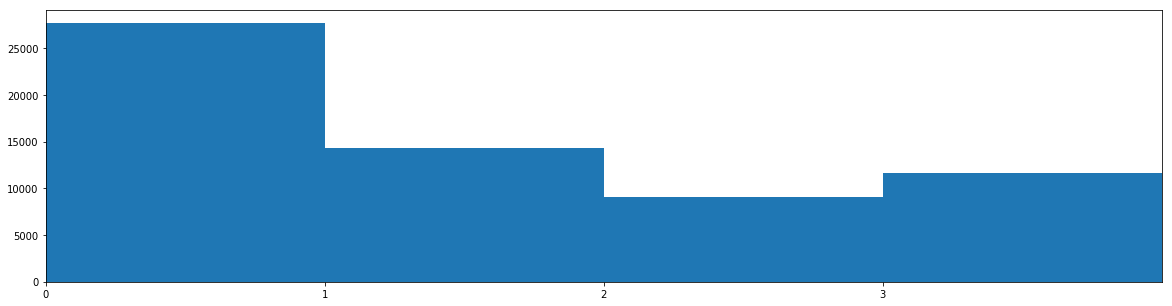

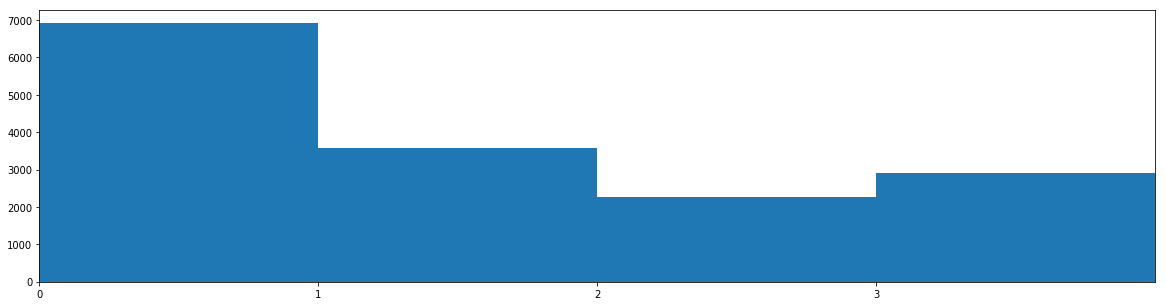

In [0]:
#@title Caricamento dei dati { vertical-output: true, display-mode: "form" }

if 'trainingData' in locals():
  del trainingData
  del validationData
  del validationLabels
  del trainingLabels

trainingDir = rootPath + 'data/training/'
validationDir = rootPath + 'data/validation/'

width = 48#@param{type:'integer'}
height = 48#@param{type:'integer'}
#@markdown Seed per la genezione di nuove immagini e la scelta casuale per custom
#@markdown load
randomSeed = -3850#@param{type:'integer'}

#riproducibilità dei training
resetSeed(15 + randomSeed)

#@markdown Aggiunge o rimuove delle immagini dalla caassi per cercare di bilanciarle
useCustomLoad = False #@param {type:"boolean"}
#@markdown Bilancia le classi senza utilizzare i paremtri custom nel codice (richiede useCustomLoad = True)
balanceClass = False #@param {type:"boolean"}
customRatio = { 
                  0 : 1.3,
                  1 : 0.5,
                  2 : 0.5,
                  3 : 0.7,
                  4 : 0.5,
                  5 : 0.5,
                  6 : 1,
                  7 : 0.7,
                  8 : 0.7,
                  9 : 0.7,
                  10 : 0.5,
                  11 : 0.7,
                  12 : 0.5,
                  13 : 0.5,
                  14 : 1,
                  15 : 1,
                  16 : 1,
                  17 : 1,
                  18 : 0.7,
                  19 : 1.3,
                  20 : 1,
                  21 : 1,
                  22 : 1,
                  23 : 1,
                  24 : 1.2,
                  25 : 0.5,
                  26 : 0.7,
                  27 : 1.2,
                  28 : 1,
                  29 : 1,
                  30 : 1,
                  31 : 1,
                  32 : 1.2,
                  33 : 1,
                  34 : 1,
                  35 : 0.7,
                  36 : 1,
                  37 : 1.2,
                  38 : 0.5,
                  39 : 1,
                  40 : 1,
                  41 : 1,
                  42 : 1
              }

useDataAugmentation = True #@param {type:"boolean"}
#Numero di immagini da generare per ogni immagine originale
NUMBER_OF_TRAINING_AUG = 1 #@param {type:"slider", min:0, max:20, step:1}
NUMBER_OF_VALIDATION_AUG = 1 #@param {type:"slider", min:0, max:5, step:1}

#generatore utilizzato se customLoad > 1
generatorCustomLoad = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=5,
    width_shift_range=3,
    height_shift_range=3,
    shear_range=0.1,
    zoom_range=(0.95,1.05),
    channel_shift_range=0.01)

#generatore utilizzato per le immagni di training
generatorTraining = keras.preprocessing.image.ImageDataGenerator(
    brightness_range = (0.25,0.6),
    rotation_range=25,
    width_shift_range=8,
    height_shift_range=8,
    shear_range=15,
    zoom_range=(0.4,1.15),
    channel_shift_range=0.13)

#generatore utilizzato per le immagini di validation
generatorValidation = keras.preprocessing.image.ImageDataGenerator(
    brightness_range = (0.25,0.7),
    rotation_range=25,
    width_shift_range=8,
    height_shift_range=8,
    shear_range=0.4,
    zoom_range=(0.4,1.15),
    channel_shift_range=0.12)

# se non utilizzo dei ratio personalizzati li setto tutti a 1
if useCustomLoad == False:
  for key in customRatio.keys():
    customRatio[key] = 1.0

# ratio calcolati in modo automatico per bilanciare le classi (bisogna settare i flag)
if useCustomLoad == True and balanceClass == True:
  trClassCount = {}
  files = list(filter(lambda fn : fn.startswith('resized'), os.listdir(trainingDir)))
  for fileName in files:
    classLabel = int(fileName.replace("resized",""))
    numFilePath = trainingDir + 'num' + str(classLabel)
    with open(numFilePath, 'r') as file:
      originalNum = int(file.readline())
      trClassCount[classLabel] = originalNum

  newMin = min(trClassCount.values()) * 1.3
  for key in trClassCount.keys():
    val =  trClassCount[key]
    if val < newMin:
      customRatio[key] = max(newMin/val, 1.3)
    elif val == newMin:
      customRatio[key] = 1.0
    elif val > newMin:
      if val > newMin/2:
        customRatio[key] = max(newMin/val, 0.4)
      else:
        customRatio[key] = max(newMin/val, 0.5)

# numero di immagini originali disponibili per ogni classe
trainingClassCount = {}
# numero di immagini di training totali
totalTrainingCount = 0

# recupero il numero di immagini di training disponibili per ogni classe
files = list(filter(lambda fn : fn.startswith('resized'), os.listdir(trainingDir)))
for fileName in files:
  classLabel = int(fileName.replace("resized",""))
  numFilePath = trainingDir + 'num' + str(classLabel)
  with open(numFilePath, 'r') as file:
    originalNum = int(file.readline())
    trainingClassCount[classLabel] = originalNum
    # il numero totale tiene conto del custom ratio
    totalTrainingCount += round(originalNum * customRatio[classLabel])

if useDataAugmentation == True:
  totalTrainingCount = totalTrainingCount * (NUMBER_OF_TRAINING_AUG + 1)

print("Training images (no pad):", totalTrainingCount)

# se uso le TPU in tf 1.13 il numero di immagini deve essere divisibile per 8
trainingPadEnd = False

if useTPU == True and tfVersion()['MAJOR'] == 1 and tfVersion()['MAJOR'] <= 13:
  if totalTrainingCount % 8 != 0:
    trainingToPad = 8 - (totalTrainingCount % 8)
    totalTrainingCount = totalTrainingCount + (8 - (totalTrainingCount % 8))
    trainingPadEnd = True
  
#preparo gli array che contengono le img di training
trainingData = np.empty((totalTrainingCount, width, height, 3), dtype='float32')
trainingLabels = np.empty((totalTrainingCount), dtype='int32')

# numero di immagini originali disponibili per ogni classe
validationClassCount = {}
# numero di immagini di validation totali
totalValidationCount = 0

# recupero il numero di immagini di training disponibili per ogni classe
for fileName in files:
  classLabel = int(fileName.replace("resized",""))
  numFilePath = validationDir + 'num' + str(classLabel)
  with open(numFilePath, 'r') as file:
    numFile = int(file.readline())
    validationClassCount[classLabel] = numFile
    totalValidationCount += numFile

if useDataAugmentation == True:
  totalValidationCount = totalValidationCount * (NUMBER_OF_VALIDATION_AUG + 1)

print("Validation images (no pad):", totalValidationCount)

# se uso le TPU in tf 1.13 il numero di immagini deve essere divisibile per 8
validationPadEnd = False 

if useTPU == True and tfVersion()['MAJOR'] == 1 and tfVersion()['MAJOR'] <= 13:
    if totalValidationCount % 8 != 0:
      # se uso le TPU la lunghezza dei dati deve essere divisibile per 8
      validationToPad = 8 - (totalValidationCount % 8)
      totalValidationCount = totalValidationCount + (8 - (totalValidationCount % 8))
      validationPadEnd = True
  
#preparo gli array che contengono le img di validation
validationData = np.empty((totalValidationCount, width, height, 3), dtype='float32')
validationLabels = np.empty((totalValidationCount), dtype='int32')

print('Total', totalValidationCount + totalTrainingCount)
if useDataAugmentation == True:
  print("Data augmentation training", NUMBER_OF_TRAINING_AUG, "validation", NUMBER_OF_VALIDATION_AUG)
else:
  print("Data augmentation : OFF")

#numero di immagini elaborate  
validationCount = 0
trainingCount = 0
loadedClass = 0

#caricamento dati
for fileName in files:
  classLabel = int(fileName.replace("resized",""))
  #carico le img di training originali
  trainingImages = np.memmap(trainingDir + fileName, dtype=np.uint8,
              mode='r', shape=(trainingClassCount[classLabel],width,height,3))

  imagesToLoad = round(trainingClassCount[classLabel] * customRatio[classLabel])
  #genero delle immagini aggiuntive se custom load è > 1.0
  imageToGenerate = max(0, imagesToLoad - trainingClassCount[classLabel])
  # scelgo casualmente le immagini da utilizzare per generarne di nuove
  indices = generateIndices(imageToGenerate, trainingClassCount[classLabel])
  # genero le immagini per ribilanciare le classi
  for index in indices:
    trainingData[trainingCount] = generateRandomImage(generatorCustomLoad, trainingImages[index])/255.0
    trainingLabels[trainingCount] = labelsInfo[classLabel][0]
    trainingCount += 1
  imagesToLoad = imagesToLoad - imageToGenerate
  # carico il resto delle immagini, potrei non doverle caricare tutte
  indices = generateIndices(imagesToLoad, trainingClassCount[classLabel])
  for index in indices:
    trainingData[trainingCount] = trainingImages[index]/255.0
    trainingLabels[trainingCount] = labelsInfo[classLabel][0]
    trainingCount += 1
  #carico le immagini di validation
  validationImages = np.memmap(validationDir + fileName, dtype=np.uint8,
              mode='r', shape=(validationClassCount[classLabel],width,height,3))

  for img in validationImages:
    validationData[validationCount] = img/255.0
    validationLabels[validationCount] = labelsInfo[classLabel][0]
    validationCount += 1

  loadedClass += 1
  if (loadedClass) % 5 == 0 or loadedClass == len(files):
    print('Caricamento file ', loadedClass, 'su', len(files))
# fine for caricamento classi

# per ogni immagine genero delle nuove immagini con trasformazioni casuali
if useDataAugmentation == True:
  print("Genero le immagini aggiuntive")
  resetSeed(48560  + randomSeed)
  for imageIndex in range(0, trainingCount):
    for augIndex in range(0, NUMBER_OF_TRAINING_AUG):
      trainingData[trainingCount] = generateRandomImage(generatorTraining, trainingData[imageIndex])/255.0
      trainingLabels[trainingCount] = trainingLabels[imageIndex]
      trainingCount += 1

  resetSeed(-420360  + randomSeed)
  for imageIndex in range(0, validationCount):
    for augIndex in range(0, NUMBER_OF_VALIDATION_AUG):
      validationData[validationCount] = generateRandomImage(generatorValidation, validationData[imageIndex])/255.0
      validationLabels[validationCount] = validationLabels[imageIndex]
      validationCount += 1

# Se necessario copio l'ultima immagine per rendere la lunghezza divisibile per 8
if trainingPadEnd == True:
  for index in range(1, trainingToPad + 1):
    trainingData[-index] = trainingData[len(trainingData) - (trainingToPad + 1)]
    trainingLabels[-index] = trainingLabels[len(trainingLabels) - (trainingToPad + 1)]
if validationPadEnd == True:
  for index in range(1, validationToPad + 1):
    validationData[-index] = validationData[len(validationData) - (validationToPad + 1)]
    validationLabels[-index] = validationLabels[len(validationLabels) - (validationToPad + 1)]

print("")

print('Training', trainingData.shape) 
print('Validation', validationData.shape)

# statistiche sulla distribuzione delle labels
plt.figure(figsize=(20,5))
plt.hist(trainingLabels, bins=max(trainingLabels))
plt.xticks(np.arange(0, max(trainingLabels), 1))
plt.xlim(left=0, right=max(trainingLabels))
plt.show()

plt.figure(figsize=(20,5))
plt.hist(validationLabels, bins=max(validationLabels))
plt.xticks(np.arange(0, max(validationLabels), 1))
plt.xlim(left=0, right=max(validationLabels))
plt.show()

In [0]:
def BigResNet():
  inputs = tf.keras.layers.Input(shape=(width, height, 3), name = "L0_INPUT")
  layer = buildConvBlock(inputs, layers = 3, size = 64, kernelSize = 3, poolSize = 2, poolStrides = 2, flatten = False)
  layer = buildResNetBlock(layer, 128, 128, 512)
  layer = buildResNetBlock(layer, 128, 128, 512)
  layer = buildMaxPoolLayer(layer, poolStrides = 2, poolSize = 2)
  layer = buildResNetBlock(layer, 256, 256, 1024)
  layer = buildResNetBlock(layer, 256, 256, 1024)
  layer = buildMaxPoolLayer(layer, poolStrides = 2, poolSize = 2)
  layer = buildResNetBlock(layer, 512, 512, 2048)
  outputs = buildGlobalSoftmax(layer, numberOfLabels = 5, kernelSize=3, denseDepth = 2, denseSize=128, dropout = 0.35)
  return tf.keras.Model(inputs = inputs, outputs = outputs)


In [0]:
models = Models()

trInfo = TrainingInfo.getDefaultTPU(
    trainingData,
    trainingLabels,
    validationData,
    validationLabels
)

trInfo.setParameters(
    learningRateList = [0.001],
    fineTuningIterations = 4,
    mainEpochs = 300,
    fineTuningEpochs = 75,
    batchSize = 512,
    validationFrequency = 5,
    metrics = ['sparse_categorical_accuracy']
)

models.addModel('BigResNetGroupDetection', BigResNet, trInfo)

In [0]:
#@title Training group { vertical-output: true, display-mode: "form" }
cleanLastSession = False #@param {type:"boolean"}
if 'lastSession' in locals():
  if cleanLastSession == True:
    for trainedModel in lastSession:
      print("Rimuovo il training del modello", trainedModel)
      shutil.rmtree(trainedModel)
    lastSession = []
else:
  lastSession = []
#@markdown ---
verboseTraining = 1 #@param {type:"integer"}
#@markdown ---
mainTrainingEarlyStoppingDelta = 0.005 #@param {type:"number"}
mainTrainingEarlyStoppinPatience = 15 #@param {type:"integer"}
fineTuningEarlyStoppingDelta = 0.001 #@param {type:"number"}
fineTuningEarlyStoppinPatience = 15 #@param {type:"integer"}
#@markdown ---

trainingPath = rootPath + 'trainingPhaseGroupModel/'


dataToLog  = ["AUG : "+ str(useDataAugmentation)+"\n",
                     "TR_AUG : " + str(NUMBER_OF_TRAINING_AUG)+"\n",
                     "VAL_AUG : " + str(NUMBER_OF_VALIDATION_AUG)+"\n",
                     "randomSeed : " + str(randomSeed)]
if "useCustomLoad" in locals() and useCustomLoad == True:
  dataToLog.append("Custom_load : " + str(useCustomLoad)+"\n")
  dataToLog.append("Custom_ratio : " + str(customRatio) + "\n")  
        
train(tpu_address,
  trainingPath,
  models, 
  verboseTraining = 1,
  mainTrainingEarlyStoppingDelta = mainTrainingEarlyStoppingDelta,
  mainTrainingEarlyStoppinPatience = mainTrainingEarlyStoppinPatience,
  fineTuningEarlyStoppingDelta = fineTuningEarlyStoppingDelta,
  fineTuningEarlyStoppinPatience = fineTuningEarlyStoppinPatience,
  stringToLog = ''.join(dataToLog),
  lastSession = lastSession)
  
    
print("Fine training")

In [0]:
#@title group test
testDir = rootPath + 'data/test/'
numFilePath = testDir + 'numTestData'

with open(numFilePath, 'r') as file:
  numberOfTestImages = int(file.readline())
  
width = 48
height = 48
  
testImages = np.memmap(testDir + "testData", dtype=np.uint8,
                mode='r', shape=(numberOfTestImages,width,height,3))

if tfVersion()['MAJOR'] == 1 and tfVersion()['MINOR'] <= 13:
  if len(testImages) % 8 != 0:
    testData = np.empty((len(testImages) + (8-len(testImages) % 8), width, height, 3), dtype=np.float32)
  else:
    testData = np.empty((len(testImages), width, height, 3), dtype=np.float32)
else:
  testData = np.empty((len(testImages), width, height, 3), dtype=np.float32)

count = 0
for image in testImages:
  testData[count] = image / 255.0
  count += 1

if tfVersion()['MAJOR'] == 1 and tfVersion()['MINOR'] <= 13:
  if len(testImages) % 8 != 0:
    for index in range(len(testData),len(testImages) + (8-len(testImages) % 8)):
      testData[index] = testData[-1]
  
print(len(testData))

predictions = testModel(tpu_address,
                         [BigResNet],
                         [
                          ['/gdrive/My Drive/DatasetSegnaliStradali/GTSRB/trainingPhaseGroupModel/BigResNetGroupDetection_2019_6_22_15_51_28/0.006/FineTuning/0.00075/weights/epoch_15_valLoss_0.0379.hdf5',
                           '/gdrive/My Drive/DatasetSegnaliStradali/GTSRB/trainingPhaseGroupModel/BigResNetGroupDetection_2019_6_22_22_7_56/0.001/FineTuning/0.0005/weights/epoch_75_valLoss_0.0387.hdf5',
                           '/gdrive/My Drive/DatasetSegnaliStradali/GTSRB/trainingPhaseGroupModel/BigResNetGroupDetection_2019_6_23_11_56_34/0.001/FineTuning/6.25e-05/weights/epoch_05_valLoss_0.0201.hdf5']
                         ],
                         testData
                       )  

12630
Test model 0 weights 0
25/25 [==============================] - 57s 2s/step
Test model 0 weights 1
25/25 [==============================] - 57s 2s/step
Test model 0 weights 2
25/25 [==============================] - 74s 3s/step


In [0]:
#@title group evaluation

labels = np.load(testDir + "labels.npy")
groupLabels = np.zeros((len(labels)), dtype="int32")

for i in range(len(labels)):
  groupLabels[i] = labelsInfo[labels[i]][0]

predictionEvaluation(predictions, groupLabels[:numberOfTestImages], [0,1,2], topN = 5)

TOP 1 corrette 12619 su 12630 ( 11 ) 99.91290577988914 %
TOP 2 corrette 12629 su 12630 ( 1 ) 99.9920823436263 %
TOP 3 corrette 12630 su 12630 ( 0 ) 100.0 %
TOP 4 corrette 12630 su 12630 ( 0 ) 100.0 %
TOP 5 corrette 12630 su 12630 ( 0 ) 100.0 %

TOP1 distribuzione:
{0: 5669, 1: 2790, 2: 1765, 3: 2035, 4: 360}
0 5669 1
Classe 0] corrette 5669 su 5670 (1) 99.98236331569666%
1 2790 0
Classe 1] corrette 2790 su 2790 (0) 100.0%
2 1765 5
Classe 2] corrette 1765 su 1770 (5) 99.71751412429379%
3 2035 5
Classe 3] corrette 2035 su 2040 (5) 99.75490196078431%
4 360 0
Classe 4] corrette 360 su 360 (0) 100.0%


MODELLO 0 E 2

TOP 1 corrette 12622 su 12630 ( 8 ) 99.93665874901029 %
TOP 2 corrette 12627 su 12630 ( 3 ) 99.97624703087887 %
TOP 3 corrette 12630 su 12630 ( 0 ) 100.0 %
TOP 4 corrette 12630 su 12630 ( 0 ) 100.0 %
TOP 5 corrette 12630 su 12630 ( 0 ) 100.0 %

TOP1 distribuzione:
{0: 5669, 1: 2790, 2: 1764, 3: 2040, 4: 359}
0 5669 1
Classe 0] corrette 5669 su 5670 (1) 99.98236331569666%
1 2790 0
Classe 1] corrette 2790 su 2790 (0) 100.0%
2 1764 6
Classe 2] corrette 1764 su 1770 (6) 99.66101694915255%
3 2040 0
Classe 3] corrette 2040 su 2040 (0) 100.0%
4 359 1
Classe 4] corrette 359 su 360 (1) 99.72222222222223%

# ***Segue l'allenamento dei singoli modelli***

Tr AUG :  [20, 1, 1, 2, 1, 1, 8, 2, 2, 2, 1, 2, 2, 2, 8, 6, 8, 5, 2, 13, 9, 10, 8, 6, 9, 1, 5, 10, 6, 10, 7, 3, 8, 7, 12, 4, 12, 21, 2, 13, 13, 8, 8]
Val AUG :  [2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 3, 4, 3, 4, 7, 3, 5, 5, 4, 4]
Caricamento file  5 su 43
Caricamento file  10 su 43
Caricamento file  15 su 43
Caricamento file  20 su 43
Caricamento file  25 su 43
Caricamento file  30 su 43
Caricamento file  35 su 43
Caricamento file  40 su 43
Caricamento file  43 su 43

Genero le immagini aggiuntive necessarie:

Gruppo 0 training terminato
Gruppo 1 training terminato
Gruppo 2 training terminato
Gruppo 3 training terminato
Gruppo 4 training terminato
Gruppo 0 validation terminato
Gruppo 1 validation terminato
Gruppo 2 validation terminato
Gruppo 3 validation terminato
Gruppo 4 validation terminato
Fine padding


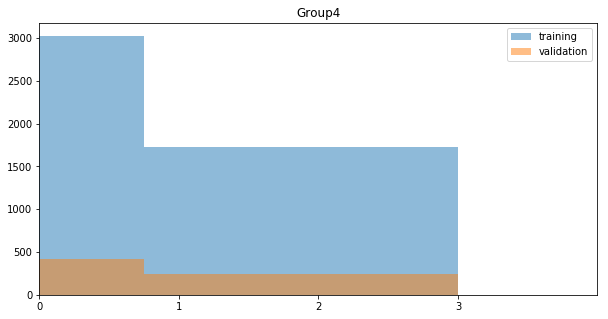

In [0]:
#@title Caricamento dei dati { vertical-output: true, display-mode: "form" }

if 'trainingData' in locals():
  del trainingData
  del trainingLabels
if 'validationData' in locals():  
  del validationData
  del validationLabels

trainingDir = rootPath + 'data/training/'
validationDir = rootPath + 'data/validation/'

groupInfo = {
    0 : 'prohibitory',
    1 : 'danger',
    2 : 'mandatory',
    3 : 'others',
    4 : 'limitsEnd'
}

labelsInfo = {
    # labelNumber : (group,labelInsideGroup, description)
    0 : (0,0, '20 km/h'),
    1 : (0,1, '30 km/h'),
    2 : (0,2, '50 km/h'),
    3 : (0,3, '60 km/h'),
    4 : (0,4, '70 km/h'),
    5 : (0,5, '80 km/h'),
    6 : (4,0, '80 km/h end'),
    7 : (0,6, '100 km/h'),
    8 : (0,7, '120 km/h'),
    9 : (0,8, 'No overtaking'),
    10 : (0,9, 'No overtaking for tracks'),
    11 : (1,0, 'Crossroad with secondary way'),
    12 : (3,0, 'Main road'),
    13 : (3,1,  'Give way'),
    14 : (3,2, 'Stop'),
    15 : (0,10,  'Road up'),
    16 : (0,11, 'Road up for track'),
    17 : (3,3,  'Brock'),
    18 : (1,1, 'Other dangerous'),
    19 : (1,2, 'Turn left'),
    20 : (1,3, 'Turn right'),
    21 : (1,4, 'Winding road'),
    22 : (1,5, 'Hollow road'),
    23 : (1,6, 'Slippery road'),
    24 : (1,7, 'Narrowing road'),
    25 : (1,8, 'Roadwork'),
    26 : (1,9, 'Traffic light'),
    27 : (1,10, 'Pedestrian'),
    28 : (1,11, 'Children'),
    29 : (1,12, 'Bike'),
    30 : (1,13, 'Snow'),
    31 : (1,14, 'Deer'),
    32 : (4,1, 'End of the limits'),
    33 : (2,0, 'Only right'),
    34 : (2,1, 'Only left'),
    35 : (2,2, 'Only straight'),
    36 : (2,3, 'Only straight and right'),
    37 : (2,4, 'Only straight and left'),
    38 : (2,5, 'Take right'),
    39 : (2,6, 'Take left'),
    40 : (2,7, 'Circle crossroad'),
    41 : (4,2, 'End of overtaking limit'),
    42 : (4,3, 'End of overtaking limit for track')
}

#@markdown Seed per la genezione di nuove immagini e la scelta casuale per custom
#@markdown load
randomSeed = 4502032#@param{type:'integer'}

#riproducibilità dei training
resetSeed(15 + randomSeed)

#@markdown ---
loadG0 = False #@param {type:"boolean"}
loadG1 = False #@param {type:"boolean"}
loadG2 = False #@param {type:"boolean"}
loadG3 = False #@param {type:"boolean"}
loadG4 = True #@param {type:"boolean"}

loadGroup = [loadG0, loadG1, loadG2, loadG3, loadG4]
#@markdown ---
useDataAugmentation = True #@param {type:"boolean"}
#@markdown Se selezionato ignora i valori assegnati ai gruppi sottostanti e usa 
#@markdown un valore perogni label invece che ogni gruppo. Sono definiti nel codice
usePerLabelDataAug = True #@param {type:"boolean"}
#Numero di immagini da generare per ogni immagine originale
NUMBER_OF_TRAINING_AUG_G0 = 6 #@param {type:"slider", min:0, max:20, step:1}
NUMBER_OF_VALIDATION_AUG_G0 = 2 #@param {type:"slider", min:0, max:5, step:1}
NUMBER_OF_TRAINING_AUG_G1 = 8 #@param {type:"slider", min:0, max:20, step:1}
NUMBER_OF_VALIDATION_AUG_G1 = 2 #@param {type:"slider", min:0, max:5, step:1}
NUMBER_OF_TRAINING_AUG_G2 = 12 #@param {type:"slider", min:0, max:20, step:1}
NUMBER_OF_VALIDATION_AUG_G2 = 2 #@param {type:"slider", min:0, max:5, step:1}
NUMBER_OF_TRAINING_AUG_G3 = 12 #@param {type:"slider", min:0, max:20, step:1}
NUMBER_OF_VALIDATION_AUG_G3 = 2 #@param {type:"slider", min:0, max:5, step:1}
NUMBER_OF_TRAINING_AUG_G4 = 16 #@param {type:"slider", min:0, max:20, step:1}
NUMBER_OF_VALIDATION_AUG_G4 = 2 #@param {type:"slider", min:0, max:5, step:1}

# da modificare se si vuole alterare la distribuzione delle classi
NUMBER_AUG_BY_LABEL = { 
                0 : ( 20 , 2 ), # group 0  label inside group 0
                1 : ( 1 , 2 ), # group 0  label inside group 1
                2 : ( 1 , 2 ), # group 0  label inside group 2
                3 : ( 2 , 2 ), # group 0  label inside group 3
                4 : ( 1 , 2 ), # group 0  label inside group 4
                5 : ( 1 , 2 ), # group 0  label inside group 5
                6 : ( 8 , 4 ), # group 4  label inside group 0
                7 : ( 2 , 2 ), # group 0  label inside group 6
                8 : ( 2 , 2 ), # group 0  label inside group 7
                9 : ( 2 , 2 ), # group 0  label inside group 8
                10 : ( 1 , 2 ), # group 0  label inside group 9
                11 : ( 2 , 2 ), # group 1  label inside group 0
                12 : ( 2 , 2 ), # group 3  label inside group 0
                13 : ( 2 , 2 ), # group 3  label inside group 1
                14 : ( 8 , 2 ), # group 3  label inside group 2
                15 : ( 6 , 2 ), # group 0  label inside group 10
                16 : ( 8 , 2 ), # group 0  label inside group 11
                17 : ( 5 , 2 ), # group 3  label inside group 3
                18 : ( 2 , 2 ), # group 1  label inside group 1
                19 : ( 13 , 2 ), # group 1  label inside group 2
                20 : ( 9 , 2 ), # group 1  label inside group 3
                21 : ( 10 , 2 ), # group 1  label inside group 4
                22 : ( 8 , 2 ), # group 1  label inside group 5
                23 : ( 6 , 2 ), # group 1  label inside group 6
                24 : ( 9 , 2 ), # group 1  label inside group 7
                25 : ( 1 , 2 ), # group 1  label inside group 8
                26 : ( 5 , 2 ), # group 1  label inside group 9
                27 : ( 10 , 2 ), # group 1  label inside group 10
                28 : ( 6 , 2 ), # group 1  label inside group 11
                29 : ( 10 , 2 ), # group 1  label inside group 12
                30 : ( 7 , 2 ), # group 1  label inside group 13
                31 : ( 3 , 2 ), # group 1  label inside group 14
                32 : ( 8 , 4 ), # group 4  label inside group 1
                33 : ( 7 , 3 ), # group 2  label inside group 0
                34 : ( 12 , 4 ), # group 2  label inside group 1
                35 : ( 4 , 3 ), # group 2  label inside group 2
                36 : ( 12 , 4 ), # group 2  label inside group 3
                37 : (21 , 7 ), # group 2  label inside group 4
                38 : ( 2 , 3 ), # group 2  label inside group 5
                39 : ( 13 , 5 ), # group 2  label inside group 6
                40 : ( 13, 5 ), # group 2  label inside group 7
                41 : ( 8 , 4 ), # group 4  label inside group 2
                42 : ( 8 , 4 ), # group 4  label inside group 3
              }

NUMBER_AUG_BY_GROUP = [
        (NUMBER_OF_TRAINING_AUG_G0, NUMBER_OF_VALIDATION_AUG_G0),
        (NUMBER_OF_TRAINING_AUG_G1, NUMBER_OF_VALIDATION_AUG_G1),
        (NUMBER_OF_TRAINING_AUG_G2, NUMBER_OF_VALIDATION_AUG_G2),
        (NUMBER_OF_TRAINING_AUG_G3, NUMBER_OF_VALIDATION_AUG_G3),
        (NUMBER_OF_TRAINING_AUG_G4, NUMBER_OF_VALIDATION_AUG_G4)
        ]
                  
NUMBER_OF_TRAINING_AUG = [0 for i in range(43)]
NUMBER_OF_VALIDATION_AUG = [0 for i in range(43)]

if useDataAugmentation == True:
  for key in labelsInfo.keys():
    if usePerLabelDataAug == True:
      NUMBER_OF_TRAINING_AUG[key] = NUMBER_AUG_BY_LABEL[key][0]
      NUMBER_OF_VALIDATION_AUG[key] = NUMBER_AUG_BY_LABEL[key][1]
    else:
      NUMBER_OF_TRAINING_AUG[key] = NUMBER_AUG_BY_GROUP[labelsInfo[key]][0]
      NUMBER_OF_VALIDATION_AUG[key] = NUMBER_AUG_BY_GROUP[labelsInfo[key]][1]

print("Tr AUG : ", NUMBER_OF_TRAINING_AUG)
print("Val AUG : ", NUMBER_OF_VALIDATION_AUG)

# parametri generatore training per gruppo
brightness_range_training = [
    (0.25,0.6), (0.25,0.6), (0.25,0.6), (0.25,0.6), (0.2,0.7)
]
rotation_range_training = [25, 25, 25, 25,35]
width_shift_range_training=[8,8,8,8,8]
height_shift_range_training=[8,8,8,8,8]
shear_range_training=[15,15,15,15,15]
zoom_range_training=[(0.4,1.15),(0.4,1.15),(0.4,1.15),(0.4,1.15),(0.3,1.15)]
channel_shift_range_training=[0.13,0.13,0.13,0.13,0.10]

# parametri generatore validation per gruppo
brightness_range_validation = [
    (0.25,0.6), (0.25,0.6), (0.25,0.6), (0.25,0.6), (0.3,0.6)
]
rotation_range_validation = [25, 25, 25, 25, 25]
width_shift_range_validation=[8,8,8,8,8]
height_shift_range_validation=[8,8,8,8,8]
shear_range_validation=[15,15,15,15,15]
zoom_range_validation=[(0.4,1.15),(0.4,1.15),(0.4,1.15),(0.4,1.15),(0.4,1.15)]
channel_shift_range_validation=[0.13,0.13,0.13,0.13,0.15]

generatorTraining = []
generatorValidation= []

for group in range(len(groupInfo.keys())):
  #generatore utilizzato per le immagni di training
  generatorTraining.append(keras.preprocessing.image.ImageDataGenerator(
      brightness_range = brightness_range_training[group],
      rotation_range=rotation_range_training[group],
      width_shift_range=width_shift_range_training[group],
      height_shift_range=height_shift_range_training[group],
      shear_range=shear_range_training[group],
      zoom_range=zoom_range_training[group],
      channel_shift_range=channel_shift_range_training[group]))

  #generatore utilizzato per le immagini di validation
  generatorValidation.append(keras.preprocessing.image.ImageDataGenerator(
      brightness_range = brightness_range_validation[group],
      rotation_range=rotation_range_validation[group],
      width_shift_range=width_shift_range_validation[group],
      height_shift_range=height_shift_range_validation[group],
      shear_range=shear_range_validation[group],
      zoom_range=zoom_range_validation[group],
      channel_shift_range=channel_shift_range_validation[group]))

# numero di immagini originali disponibili per ogni classe
trainingClassCount = {}
#numero di immagini di training totali suddivide per gruppo
totalTrainingCount = [0 for group in groupInfo.keys()]
loadLabel = [False for i in range(43)]
# recupero il numero di immagini di training disponibili per ogni classe
files = list(filter(lambda fn : fn.startswith('resized'), os.listdir(trainingDir)))
for fileName in files:
  classLabel = int(fileName.replace("resized",""))
  numFilePath = trainingDir + 'num' + str(classLabel)
  with open(numFilePath, 'r') as file:
    originalNum = int(file.readline())
    trainingClassCount[classLabel] = originalNum
    groupIndex = labelsInfo[classLabel][0]
    if loadGroup[groupIndex] == True:
      loadLabel[classLabel] = True
      totalTrainingCount[groupIndex] += originalNum * (NUMBER_OF_TRAINING_AUG[classLabel] + 1)

# se uso le TPU in tf 1.13 il numero di immagini deve essere divisibile per 8
trainingPadEnd = [False for group in groupInfo.keys()]
trainingToPad = [0 for group in groupInfo.keys()]
if useTPU == True and tfVersion()['MAJOR'] == 1 and tfVersion()['MAJOR'] <= 13:
  for groupIndex in range(len(groupInfo.keys())):
    if loadGroup[groupIndex] and totalTrainingCount[groupIndex] % 8 != 0:
      # se uso le TPU la lunghezza dei dati deve essere divisibile per 8
      trainingToPad[groupIndex] = 8 - (totalTrainingCount[groupIndex]  % 8)
      totalTrainingCount[groupIndex] = totalTrainingCount[groupIndex]  + (trainingToPad[groupIndex])
      trainingPadEnd[groupIndex] = True
  
#preparo gli array che contengono le img di training
trainingData = []
trainingLabels = []
originalTrainingLabels = []

for groupIndex in range(len(groupInfo.keys())):
  trainingData.append(np.empty((totalTrainingCount[groupIndex], width, height, 3), dtype="float32"))
  trainingLabels.append( np.empty((totalTrainingCount[groupIndex]), dtype='int32'))
  originalTrainingLabels.append( np.empty((totalTrainingCount[groupIndex]), dtype='int32'))

# numero di immagini originali disponibili per ogni classe
validationClassCount = {}
#leggo quante img ci sono per ogni class di validation
totalValidationCount = [0 for group in groupInfo.keys()]


# recupero il numero di immagini di training disponibili per ogni classe
for fileName in files:
  classLabel = int(fileName.replace("resized",""))
  numFilePath = validationDir + 'num' + str(classLabel)
  with open(numFilePath, 'r') as file:
    numFile = int(file.readline())
    validationClassCount[classLabel] = numFile
    groupIndex = labelsInfo[classLabel][0]
    if loadGroup[groupIndex] == True:
      totalValidationCount[groupIndex] += numFile * (NUMBER_OF_VALIDATION_AUG[classLabel]+ 1)

# se uso le TPU in tf 1.13 il numero di immagini deve essere divisibile per 8
validationPadEnd = [False for group in groupInfo.keys()]
validationToPad = [0 for group in groupInfo.keys()]
if tfVersion()['MAJOR'] == 1 and tfVersion()['MAJOR'] <= 13:
  for groupIndex in range(len(groupInfo.keys())):
    if totalValidationCount[groupIndex] % 8 != 0:
      validationToPad[groupIndex] = 8 - (totalValidationCount[groupIndex]  % 8)
      totalValidationCount[groupIndex] = totalValidationCount[groupIndex]  + (validationToPad[groupIndex])
      validationPadEnd[groupIndex] = True
  
#preparo gli array che contengono le img di validation
validationData = []
validationLabels = []
originalValidationLabels = []
for groupIndex in range(len(groupInfo.keys())):
  validationData.append(np.empty((totalValidationCount[groupIndex], width, height, 3), dtype="float32"))
  validationLabels.append( np.empty((totalValidationCount[groupIndex]), dtype='int32'))
  originalValidationLabels.append( np.empty((totalValidationCount[groupIndex]), dtype='int32'))

#numero di immagini elaborate per gruppo
validationCount = [0 for group in groupInfo.keys()]
trainingCount = [0 for group in groupInfo.keys()]
loadedClass = 0

#caricamento dati
for fileName in files:
  classLabel = int(fileName.replace("resized",""))
  if loadLabel[classLabel] == True:
    #carico le img di training originali
    trainingImages = np.memmap(trainingDir + fileName, dtype=np.uint8,
                mode='r', shape=(trainingClassCount[classLabel],width,height,3))

    imagesToLoad =trainingClassCount[classLabel]
    group = labelsInfo[classLabel][0]
    indices = generateIndices(imagesToLoad, trainingClassCount[classLabel])
    for index in indices:
      trainingData[group][trainingCount[group]]  = trainingImages[index]/255.0
      trainingLabels[group][trainingCount[group]] = labelsInfo[classLabel][1]
      originalTrainingLabels[group][trainingCount[group]] = classLabel
      trainingCount[group] += 1
    #carico le immagini di validation
    validationImages = np.memmap(validationDir + fileName, dtype=np.uint8,
                mode='r', shape=(validationClassCount[classLabel],width,height,3))

    for img in validationImages:
      validationData[group][validationCount[group]] = img/255.0
      validationLabels[group][validationCount[group]] = labelsInfo[classLabel][1]
      originalValidationLabels[group][validationCount[group]] = classLabel
      validationCount[group] += 1

  loadedClass += 1
  if (loadedClass) % 5 == 0 or loadedClass == len(files):
    print('Caricamento file ', loadedClass, 'su', len(files))

# fine for caricamento classi

# per ogni immagine genero delle nuove immagini con trasformazioni casuali
print("\nGenero le immagini aggiuntive necessarie:\n")
resetSeed(48560  + randomSeed)
for group in range(len(groupInfo.keys())):
  for imageIndex in range(0, trainingCount[group]):
    #print(group, imageIndex, originalTrainingLabels[group][imageIndex], NUMBER_OF_TRAINING_AUG[originalTrainingLabels[group][imageIndex]])    
    for augIndex in range(0, NUMBER_OF_TRAINING_AUG[originalTrainingLabels[group][imageIndex]]):
      trainingData[group][trainingCount[group]] = generateRandomImage(generatorTraining[group], trainingData[group][imageIndex])/255.0
      trainingLabels[group][trainingCount[group]] = trainingLabels[group][imageIndex]
      trainingCount[group] += 1
  print("Gruppo", group, "training terminato")

resetSeed(-420360  + randomSeed)
for group in range(len(groupInfo.keys())):
  for imageIndex in range(0, validationCount[group]):
    for augIndex in range(0, NUMBER_OF_VALIDATION_AUG[originalValidationLabels[group][imageIndex]]):
      validationData[group][validationCount[group]] = generateRandomImage(generatorValidation[group], validationData[group][imageIndex])/255.0
      validationLabels[group][validationCount[group]] = validationLabels[group][imageIndex]
      validationCount[group] += 1
  print("Gruppo", group, "validation terminato")

# Se necessario copio l'ultima immagine per rendere la lunghezza divisibile per 8
for group in range(len(groupInfo.keys())):       
  if trainingPadEnd[group] == True:
    for index in range(1, trainingToPad[group] + 1):
      trainingData[group][-index] = trainingData[group][len(trainingData[group]) - (trainingToPad[group] + 1)]
      trainingLabels[group][-index] = trainingLabels[group][len(trainingLabels[group]) - (trainingToPad[group] + 1)]
    
  if validationPadEnd[group] == True:
    for index in range(1, validationToPad[group] + 1):
      validationData[group][-index] = validationData[group][len(validationData[group]) - (validationToPad[group] + 1)]
      validationLabels[group][-index] = validationLabels[group][len(validationLabels[group]) - (validationToPad[group] + 1)]
    
print("Fine padding")      

# statistiche sulla distribuzione delle labels      

for index in range(5):
  if loadGroup[index] == True:
    plt.figure(figsize=(10,5))
    maxLabel = max(trainingLabels[index])+1
    if maxLabel > 42:
      raise RuntimeError("C'è un errore grave nel codice, ricontrolla.")
    plt.hist(trainingLabels[index], alpha = 0.5, bins=maxLabel, label = "training")
    plt.hist(validationLabels[index], alpha = 0.5, bins=maxLabel, label = "validation")
    plt.xticks(np.arange(0, maxLabel, 1))
    plt.xlim(left=0, right=maxLabel)
    plt.title('Group' + str(index))
    plt.legend(loc='upper right')
    plt.show()


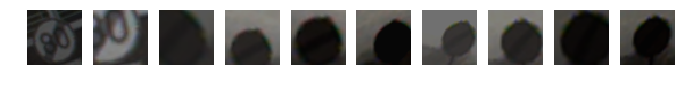

In [0]:
#@title Esempio immagini { vertical-output: true, display-mode: "form" }
numImages = 10 #@param {type:"integer"}
offset = 562 #@param {type:"integer"}
group = 4 #@param {type:"integer"}

figure = plt.figure(figsize = (30,30),constrained_layout=False)
gs = figure.add_gridspec(nrows=2, ncols=numImages, right = 0.4, left = 0.1,top = 0.2, bottom = 0.1)
count = 0
for i in range(numImages):
  ax = figure.add_subplot(gs[0,i])
  ax.imshow(validationData[group][offset + count])
  ax.axis('off')
  ax.grid(False)
  count += 1

In [0]:
def model1(numberOfLabels): 
  def closure():
    inputs = tf.keras.layers.Input(shape=(width, height, 3), name = "L0_INPUT")
    layer = buildConvBlock(inputs, layers = 3, size = 128, kernelSize = 3, poolSize = 2, poolStrides = 2, flatten = False)
    layer = buildResNetBlock(layer, 64, 64, 256)
    layer = buildResNetBlock(layer, 64, 64, 256)
    layer = buildMaxPoolLayer(layer, poolStrides = 2, poolSize = 2)
    layer = buildResNetBlock(layer, 96, 96, 384)
    layer = buildResNetBlock(layer, 96, 96, 384)
    layer = buildMaxPoolLayer(layer, poolStrides = 2, poolSize = 2)
    layer = buildResNetBlock(layer, 128, 128, 512)
    layer = buildResNetBlock(layer, 192, 192, 768)
    layer = buildMaxPoolLayer(layer, poolStrides = 2, poolSize = 2)
    layer = buildResNetBlock(layer, 256, 256, 1024)
    outputs = buildGlobalSoftmax(layer, numberOfLabels = numberOfLabels, kernelSize=3, denseDepth = 2, denseSize=128, dropout = 0.35)
    return tf.keras.Model(inputs = inputs, outputs = outputs)
  return closure

#non funciona in v1.14
def model2(numberOfLabels): 
  def closure():
    inputs = tf.keras.layers.Input(shape=(width, height, 3), name = "L0_INPUT")
    layer = buildConvBlock(inputs, layers = 3, size = 128, kernelSize = 3, poolSize = 2, poolStrides = 2, flatten = False, useBatch = True)

    layer = buildResidualInceptionBlockV4(layer, residualLayer = layer, size1x1 = 16, size3x3 = 64, size5x5 = 8, sizeMaxPool = 16, dimensionalityReduction = 0)
    layer = buildResidualInceptionBlockV4(layer, residualLayer = layer, size1x1 = 16, size3x3 = 64, size5x5 = 8, sizeMaxPool = 16, dimensionalityReduction = 0)
    layer = buildResidualInceptionBlockV4(layer, residualLayer = layer, size1x1 = 16, size3x3 = 64, size5x5 = 8, sizeMaxPool = 16, dimensionalityReduction = 0) 
    layer = buildMaxPoolLayer(layer, poolSize = 2, poolStrides = 2, flattenOutput = False)
    layer = buildResidualInceptionBlockV4(layer, residualLayer = layer, size1x1 = 32, size3x3 = 128, size5x5 = 16, sizeMaxPool = 32, dimensionalityReduction = 0)
    layer = buildResidualInceptionBlockV4(layer, residualLayer = layer, size1x1 = 32, size3x3 = 128, size5x5 = 16, sizeMaxPool = 32, dimensionalityReduction = 0)
    layer = buildResidualInceptionBlockV4(layer, residualLayer = layer, size1x1 = 32, size3x3 = 128, size5x5 = 16, sizeMaxPool = 32, dimensionalityReduction = 0)
    layer = buildMaxPoolLayer(layer, poolSize = 2, poolStrides = 2, flattenOutput = False)
    layer = buildResidualInceptionBlockV4(layer, residualLayer = layer, size1x1 = 64, size3x3 = 256, size5x5 = 32, sizeMaxPool = 64, dimensionalityReduction = 0)
    layer = buildResidualInceptionBlockV4(layer, residualLayer = layer, size1x1 = 64, size3x3 = 256, size5x5 = 32, sizeMaxPool = 64, dimensionalityReduction = 0) 
    layer = buildResidualInceptionBlockV4(layer, residualLayer = layer, size1x1 = 64, size3x3 = 256, size5x5 = 32, sizeMaxPool = 64, dimensionalityReduction = 0) 

    outputs = buildGlobalSoftmax(layer, kernelSize=3, reductionLayerSize = numberOfLabels, numberOfLabels =  numberOfLabels, denseDepth = 2,  denseSize=128, dropout = 0.35)
    return tf.keras.Model(inputs = inputs, outputs = outputs)
  return closure

def model5(numberOfLabels): 
  def closure():
    inputs = tf.keras.layers.Input(shape=(width, height, 3), name = "L0_INPUT")
    layer = buildConvBlock(inputs, layers = 3, size = 128, kernelSize = 3, poolSize = 2, poolStrides = 2, flatten = False)
    layer = buildResNetBlock(layer, 64, 64, 256)
    layer = buildResNetBlock(layer, 64, 64, 256)
    layer = buildMaxPoolLayer(layer, poolStrides = 2, poolSize = 2)
    layer = buildResNetBlock(layer, 96, 96, 384)
    layer = buildResNetBlock(layer, 96, 96, 384)
    layer = buildMaxPoolLayer(layer, poolStrides = 2, poolSize = 2)
    layer = buildResNetBlock(layer, 128, 128, 512)
    layer = buildResNetBlock(layer, 192, 192, 768)
    layer = buildMaxPoolLayer(layer, poolStrides = 2, poolSize = 2)
    layer = buildResNetBlock(layer, 256, 256, 1024)
    layer = buildResNetBlock(layer, 256, 256, 1024)
    outputs = buildGlobalSoftmax(layer, reductionLayerSize=256, numberOfLabels = numberOfLabels, kernelSize=3, denseDepth = 2, denseSize=128, dropout = 0.35)
    return tf.keras.Model(inputs = inputs, outputs = outputs)
  return closure

def model6(numberOfLabels): 
  def closure():
    inputs = tf.keras.layers.Input(shape=(width, height, 3), name = "L0_INPUT")
    layer = buildConvBlock(inputs, layers = 3, size = 128, kernelSize = 3, poolSize = 2, poolStrides = 2, flatten = False)
    layer = buildResNetBlock(layer, 64, 64, 256)
    layer = buildResNetBlock(layer, 64, 64, 256)
    layer = buildMaxPoolLayer(layer, poolStrides = 2, poolSize = 2)
    layer = buildResNetBlock(layer, 128, 128, 512)
    layer = buildResNetBlock(layer, 128, 128, 512)
    layer = buildMaxPoolLayer(layer, poolStrides = 2, poolSize = 2)
    layer = buildResNetBlock(layer, 256, 256, 1024)
    layer = buildResNetBlock(layer, 256, 256, 1024)
    layer = buildMaxPoolLayer(layer, poolStrides = 2, poolSize = 2)
    layer = buildResNetBlock(layer, 512, 512, 2048)
    outputs = buildGlobalSoftmax(layer, reductionLayerSize=256, numberOfLabels = numberOfLabels, kernelSize=3, denseDepth = 2, denseSize=128, dropout = 0.35)
    return tf.keras.Model(inputs = inputs, outputs = outputs)
  return closure

def model7(numberOfLabels):
  def closure():
      inputs = tf.keras.layers.Input(shape=(width, height, 3), name = "L0_INPUT")
      layer = buildConvBlock(inputs, layers = 3, size = 64, kernelSize = 3, poolSize = 2, poolStrides = 2, flatten = False)
      layer = buildResNetBlock(layer, 128, 128, 512)
      layer = buildResNetBlock(layer, 128, 128, 512)
      layer = buildMaxPoolLayer(layer, poolStrides = 2, poolSize = 2)
      layer = buildResNetBlock(layer, 256, 256, 1024)
      layer = buildResNetBlock(layer, 256, 256, 1024)
      layer = buildMaxPoolLayer(layer, poolStrides = 2, poolSize = 2)
      layer = buildResNetBlock(layer, 512, 512, 2048)
      outputs = buildGlobalSoftmax(layer, numberOfLabels = numberOfLabels, kernelSize=3, denseDepth = 2, denseSize=128, dropout = 0.35)
      return tf.keras.Model(inputs = inputs, outputs = outputs)
  return closure

def model8(numberOfLabels):
  MULT = 2
  L1_B = 64
  L1_A = L1_B * MULT
  L2_B = 128
  L2_A = L1_B * MULT
  L3_B = 256
  L3_A = L1_B * MULT
  
  def closure():
      inputs = tf.keras.layers.Input(shape=(width, height, 3), name = "L0_INPUT")
      layer = buildConvBlock(inputs, layers = 3, size = 16, kernelSize = 3, poolSize = 3, poolStrides = 2, flatten = False)
      layer = buildResNetBlock(layer, L1_B, L1_B, L1_A)
      layer = buildResNetBlock(layer, L1_B, L1_B, L1_A)
      layer = buildMaxPoolLayer(layer, poolStrides = 2, poolSize = 2)
      layer = buildResNetBlock(layer, L2_B, L2_B, L2_A)
      layer = buildResNetBlock(layer, L2_B, L2_B, L2_A)
      layer = buildMaxPoolLayer(layer, poolStrides = 2, poolSize = 2)
      layer = buildResNetBlock(layer, L3_B, L3_B, L3_A)
      layer = buildResNetBlock(layer, L3_B, L3_B, L3_A)
      outputs = buildGlobalSoftmax(layer, numberOfLabels = numberOfLabels)
      #outputs = buildGlobalSoftmax(layer, numberOfLabels = numberOfLabels, kernelSize=1, denseDepth = 2, denseSize=32, dropout = 0.3)
      return tf.keras.Model(inputs = inputs, outputs = outputs)
  return (closure, "MODEL8")

In [0]:
subGroupModels = Models()


for group in [4]:#range(len(groupInfo.keys())):
  if loadGroup[group] == False:
    raise RuntimeError("Non hai caricato i dati per il gruppo", group)
  trInfo = TrainingInfo.getDefaultTPU(
      trainingData[group],
      trainingLabels[group],
      validationData[group],
      validationLabels[group]
  )
  
  #uniqueLables, counts = np.unique(trainingLabels[group], return_counts=True)
  #classWeights = dict(zip(uniqueLables, 1 / (counts / max(counts))))
  
  trInfo.setParameters(
      learningRateList = [0.0005],
      fineTuningIterations = 4,
      mainEpochs = 400,
      fineTuningEpochs = 70,
      batchSize = 1024,
      validationFrequency = 10,
      validationFrequencyFT = 5,
      metrics = ['sparse_categorical_accuracy'],
      classWeights = None #non supportato attualmente
  )
  generatedModel = model8(max(trainingLabels[group]) + 1)
  subGroupModels.addModel('Res_' + generatedModel[1] + '_group' + str(group), generatedModel[0], trInfo)

In [0]:
#@title Training sub-group { vertical-output: true, display-mode: "form" }
cleanLastSession = False #@param {type:"boolean"}
if 'lastSession' in locals():
  if cleanLastSession == True:
    for trainedModel in lastSession:
      print("Rimuovo il training del modello", trainedModel)
      shutil.rmtree(trainedModel)
    lastSession = []
else:
  lastSession = []
#@markdown ---
verboseTraining = 1 #@param {type:"integer"}
#@markdown ---
mainTrainingEarlyStoppingDelta = 0.005 #@param {type:"number"}
mainTrainingEarlyStoppinPatience = 15 #@param {type:"integer"}
fineTuningEarlyStoppingDelta = 0.001 #@param {type:"number"}
fineTuningEarlyStoppinPatience = 15 #@param {type:"integer"}
#@markdown ---

trainingPath = rootPath + 'trainingPhaseGroupModel/'


dataToLog  = ["AUG : "+ str(useDataAugmentation)+"\n",
                     "TR_AUG : " + str(NUMBER_OF_TRAINING_AUG)+"\n",
                     "VAL_AUG : " + str(NUMBER_OF_VALIDATION_AUG)+"\n",
                     "randomSeed : " + str(randomSeed)]
if "useCustomLoad" in locals() and useCustomLoad == True:
  dataToLog.append("Custom_load : " + str(useCustomLoad)+"\n")
  dataToLog.append("Custom_ratio : " + str(customRatio) + "\n")  
        
history = train(tpu_address,
  trainingPath,
  subGroupModels, 
  verboseTraining = 1,
  mainTrainingEarlyStoppingDelta = mainTrainingEarlyStoppingDelta,
  mainTrainingEarlyStoppinPatience = mainTrainingEarlyStoppinPatience,
  fineTuningEarlyStoppingDelta = fineTuningEarlyStoppingDelta,
  fineTuningEarlyStoppinPatience = fineTuningEarlyStoppinPatience,
  stringToLog = ''.join(dataToLog),
  lastSession = lastSession)
  
    
print("Fine training")

 
Res_MODEL8_group4] : main training con lr0.0005 
Epoch 1/400
8/8 [==============================] - 11s 1s/step - loss: 4.3992 - sparse_categorical_accuracy: 0.2726
Epoch 2/400
8/8 [==============================] - 0s 53ms/step - loss: 3.7525 - sparse_categorical_accuracy: 0.4922
Epoch 3/400
8/8 [==============================] - 0s 55ms/step - loss: 3.3694 - sparse_categorical_accuracy: 0.6096
Epoch 4/400
8/8 [==============================] - 0s 55ms/step - loss: 3.0319 - sparse_categorical_accuracy: 0.6980
Epoch 5/400
8/8 [==============================] - 0s 54ms/step - loss: 2.7582 - sparse_categorical_accuracy: 0.7794
Epoch 6/400
8/8 [==============================] - 0s 54ms/step - loss: 2.5550 - sparse_categorical_accuracy: 0.8140
Epoch 7/400
8/8 [==============================] - 0s 55ms/step - loss: 2.3875 - sparse_categorical_accuracy: 0.8564
Epoch 8/400
8/8 [==============================] - 0s 57ms/step - loss: 2.2365 - sparse_categorical_accuracy: 0.8982
Epoch 9/400
8/

In [0]:
if 'predictions' not in locals():
  raise RuntimeError("Devi esereguire prima la cella group test")
    
predictedGroupLabels = np.zeros((len(predictions[0])),dtype="int32")

trueLabels = np.load(testDir + "labels.npy")

# dalle predictions estraggo il groupLabel
for predictionIndex in range(len(trueLabels)):
  prediction = np.zeros((5), dtype="float")
  # preparo il vettore inferenza
  for modelIndex in range(len(predictions)):
    prediction = np.add(prediction, predictions[modelIndex][predictionIndex])
  predictedGroupLabels[predictionIndex] = np.argmax(prediction)

  


# label original suddivide per gruppo in base alle inferenza e non al reale gruppo
trueLabelsByGroup = [[],[],[],[],[]]
testDataGroup = [[],[],[],[],[]]
for lIndex in range(len(predictedGroupLabels)):
  testDataGroup[predictedGroupLabels[lIndex]].append(testData[lIndex])
  trueLabelsByGroup[predictedGroupLabels[lIndex]].append(trueLabels[lIndex]) 

result = []  
maxLabels = [12,15,8,4,4]

count = 0

weights = [
    '/gdrive/My Drive/DatasetSegnaliStradali/GTSRB/trainingPhaseGroupModel/ResBalancedx2_group0_2019_6_28_18_3_36/0.001/FineTuning/0.000125/weights/epoch_10_valLoss_0.0472.hdf5',
          '/gdrive/My Drive/DatasetSegnaliStradali/GTSRB/trainingPhaseGroupModel/ResBalancedx2_group1_2019_6_29_8_29_12/0.001/FineTuning/0.000125/weights/epoch_15_valLoss_0.0280.hdf5',
          '/gdrive/My Drive/DatasetSegnaliStradali/GTSRB/trainingPhaseGroupModel/ResBalancedx2_group2_2019_6_28_13_53_56/0.001/FineTuning/0.000125/weights/epoch_25_valLoss_0.0067.hdf5',
          '/gdrive/My Drive/DatasetSegnaliStradali/GTSRB/trainingPhaseGroupModel/Res_group3_2019_6_24_8_48_1/0.0001/FineTuning/6.25e-06/weights/epoch_50_valLoss_0.1405.hdf5',
          '/gdrive/My Drive/DatasetSegnaliStradali/GTSRB/trainingPhaseGroupModel/Res_MODEL8_group4_2019_7_2_10_5_3/0.0005/FineTuning/6.25e-05/weights/epoch_15_valLoss_0.1101.hdf5']#'/gdrive/My Drive/DatasetSegnaliStradali/GTSRB/trainingPhaseGroupModel/Res_group4_2019_6_23_20_32_28/0.0001/FineTuning/6.25e-06/weights/epoch_40_valLoss_0.1579.hdf5']

for tdGroup in testDataGroup:
  if tfVersion()['MAJOR'] <= 1 and tfVersion()['MINOR'] <= 13:
    if len(tdGroup) % 8 != 0:
      for index in range(len(tdGroup),len(tdGroup) + (8-len(tdGroup) % 8)):
        tdGroup.append(tdGroup[-1])

  data = np.asarray(tdGroup, dtype=np.float32)
  if count <= 2:
    model = model7(maxLabels[count])
  if count == 3:
    model = model1(maxLabels[count])
  if count == 4:
    model = model8(maxLabels[count])[0]
  
  res = testModel(tpu_address,
                         [model],
                         [
                             [weights[count]]
                         ],
                         data)
  
  count += 1
  for r in res:
    result.append(r)
  print("fine" , count)


Test model 0 weights 0
12/12 [==============================] - 27s 2s/step
fine 1
Test model 0 weights 0
6/6 [==============================] - 15s 2s/step
fine 2
Test model 0 weights 0
4/4 [==============================] - 11s 3s/step
fine 3
Test model 0 weights 0
4/4 [==============================] - 16s 4s/step
fine 4
Test model 0 weights 0
1/1 [==============================] - 3s 3s/step
fine 5


In [0]:
lookUpTable=[
     {
         0 :0, 1:1,2:2,3:3,4:4,5:5,6:7,7:8,8:9,9:10,10:15,11:16
     }   ,
    {
        0:11,1:18,2:19,3:20,4:21,5:22,6:23,7:24,8:25,9:26,10:27,11:28,12:29,13:30,14:31
    },
    {
        0:33,1:34,2:35,3:26,4:37,5:38,6:39,7:40
    },
    {
        0:12,1:13,2:14,3:17
    },
    {
      0:6,1:32,2:41,3:42  
    }
]

index = 0
total = 0
correct = 0
for index in [0,1,2,3,4]:
  corBackup = correct
  totBackup = total
  wrongGroup = 0
  for lIndex in range(len(trueLabelsByGroup[index])):
    pred = np.argmax(result[index][lIndex])
    ## correggo con una lookup table
    pred = lookUpTable[index][pred]
    if pred == trueLabelsByGroup[index][lIndex]:
      correct += 1
    else:
      #sbagliata
      if labelsInfo[trueLabelsByGroup[index][lIndex]][0] != index:
        wrongGroup += 1
    total += 1
  print(total-totBackup, correct - corBackup, wrongGroup)
  index += 1

print(total, correct)

5675 5653 6
2790 2748 0
1769 1640 4
2036 2003 1
360 264 0
12630 12308


5675 5653 6

2790 2748 0

1769 1640 4

2036 2003

360 343

12630 12387